# QSVM for Breast Cancer Detection that will not only be created for utility, but for comparison to a SVM of each ones efficiency.

## Niko Tsiolas, July 2024

In [12]:

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, normalized_mutual_info_score
from sklearn.feature_selection import SelectKBest, f_classif
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms import QSVC
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.primitives import Sampler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from qiskit.circuit.library import PauliFeatureMap

class CustomFeatureMap(PauliFeatureMap):
    def __init__(self, feature_dimension, reps=2):
        super().__init__(feature_dimension, reps=reps, paulis=['Z'])
        self.feature_dimension = feature_dimension
        self.reps = reps

    def construct_circuit(self, x, qr=None):
        params = ParameterVector('θ', length=len(x))
        qc = super().construct_circuit(x, qr)
        
        for _ in range(self.reps):
            # Apply RY rotations
            for i in range(self.feature_dimension):
                qc.ry(params[i], i)
            
            # Apply CZ gates between adjacent qubits
            for i in range(self.feature_dimension - 1):
                qc.cz(i, i+1)
            
            # Apply parameterized RZ rotations
            for i in range(self.feature_dimension):
                qc.rz(params[i] ** 2, i)
        
        return qc

# Load the data 
data = pd.read_csv('Breast_Cancer_Data.csv')

# Separating the features and target 
X = data.drop('diagnosis', axis=1)
y = data['diagnosis']


In [13]:

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Feature selection
selector = SelectKBest(f_classif, k=10)  # Increased to 10 features
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

# Apply SMOTE for balancing the dataset
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_selected, y_train)

# Set up the quantum feature map
feature_dim = X_train_balanced.shape[1]
custom_feature_map = CustomFeatureMap(feature_dimension=feature_dim, reps=3)

# Set up the quantum kernel
quantum_kernel = FidelityQuantumKernel(feature_map=custom_feature_map)

# Create the QSVC with the quantum kernel
qsvc = QSVC(quantum_kernel=quantum_kernel)

/opt/miniconda3/envs/QiskitAlgorithms/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=10 is greater than n_features=5. All the features will be returned.
  warnings.warn(


Training QSVC with hyperparameter tuning...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters: {'C': 10.0, 'reps': 1}
Best cross-validation score: 0.8759070450996602
Making predictions...
QSVC Results:
Accuracy: 0.8771929824561403

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.72      0.82        43
           1       0.85      0.97      0.91        71

    accuracy                           0.88       114
   macro avg       0.90      0.85      0.86       114
weighted avg       0.88      0.88      0.87       114

Normalized Mutual Information Score: 0.47207756192603734


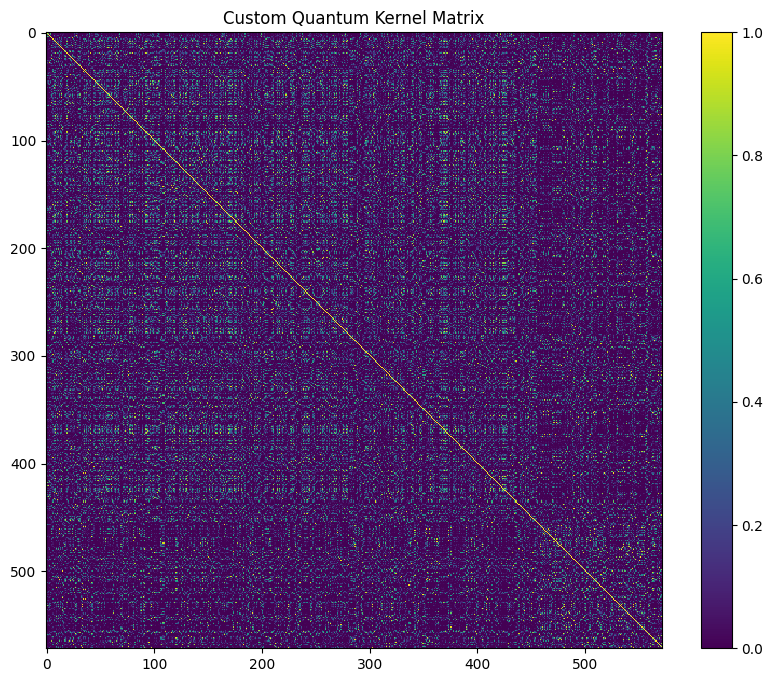

X_train_balanced shape: (572, 5)
y_train_balanced shape: (572,)
X_test_selected shape: (114, 5)
y_test shape: (114,)
Script execution completed.


In [16]:
# Hyperparameter tuning
param_grid = {
    'C': [0.1, 1.0, 10.0],
    'reps': [1, 2, 3, 4]
}

class QSVCWrapper(QSVC):
    def __init__(self, C=1.0, reps=2):
        feature_map = CustomFeatureMap(feature_dimension=feature_dim, reps=reps)
        kernel = FidelityQuantumKernel(feature_map=feature_map)
        super().__init__(quantum_kernel=kernel, C=C)
        self.reps = reps

    def get_params(self, deep=True):
        return {"C": self.C, "reps": self.reps}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        self.quantum_kernel = FidelityQuantumKernel(
            feature_map=CustomFeatureMap(feature_dimension=feature_dim, reps=self.reps)
        )
        return self

grid_search = GridSearchCV(
    estimator=QSVCWrapper(),
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=1
)

print("Training QSVC with hyperparameter tuning...")
grid_search.fit(X_train_balanced, y_train_balanced)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

best_qsvc = grid_search.best_estimator_


print("Making predictions...")
y_pred_qsvc = best_qsvc.predict(X_test_selected)

print("QSVC Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_qsvc))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_qsvc))

# Calculate normalized mutual information score
nmi_score = normalized_mutual_info_score(y_test, y_pred_qsvc)
print(f"Normalized Mutual Information Score: {nmi_score}")

# Visualize kernel matrix
kernel_matrix = best_qsvc.quantum_kernel.evaluate(X_train_balanced)
plt.figure(figsize=(10, 8))
plt.imshow(kernel_matrix, cmap='viridis', interpolation='nearest')
plt.title("Custom Quantum Kernel Matrix")
plt.colorbar()
plt.show()

# Print data shapes for debugging
print("X_train_balanced shape:", X_train_balanced.shape)
print("y_train_balanced shape:", y_train_balanced.shape)
print("X_test_selected shape:", X_test_selected.shape)
print("y_test shape:", y_test.shape)

print("Script execution completed.")